In [31]:
import pandas as pd
import sys
# Path to the directory just above 'Code'
sys.path.append('/Users/maxguo/Desktop/TS_Forecasting_Project')
from Code.Load import Loaded_Data as ld
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima

In [5]:
df = ld.combined_data

In [6]:
df = df.dropna()
df

,regionid,sizerank,regionname,regiontype,region,statename,new construction sales count,new construction mean sales price ($),mean days to pending,mean price cut ($),mean price cut (%),median sales price ($),percent sold above list (%),zillow home value index,zillow observed rent index
date,,,,,,,,,,,,,,,
2018-03-31,394716,227,"Jacksonville, NC",msa,South,NC,1539.0,1.929569e+05,56.0,5094.944958,0.027561,143500.0,0.266526,154459.528570,823.322011
2018-03-31,753899,2,"Los Angeles, CA",msa,West,CA,21998.0,1.380173e+06,35.0,44820.203428,0.031670,608333.0,0.400035,642150.555974,2200.105664
2018-03-31,394623,226,"Gainesville, GA",msa,South,GA,933.0,2.707985e+05,48.0,11497.960338,0.031285,192008.0,0.128427,211786.882602,1143.336684
2018-03-31,394765,218,"Lake Havasu City, AZ",msa,West,AZ,2235.0,2.391947e+05,59.0,8499.731706,0.033192,173667.0,0.090133,203204.620450,963.200823
2018-03-31,394380,232,"Bend, OR",msa,West,OR,1682.0,3.683550e+05,52.0,16474.326599,0.029649,370733.0,0.200968,399533.774419,1441.866819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,394355,29,"Austin, TX",msa,South,TX,9074.0,5.149174e+05,87.0,23326.246893,0.031354,443750.0,0.116435,466361.037157,1757.910625
2024-02-29,394531,84,"Des Moines, IA",msa,Midwest,IA,1967.0,4.047605e+05,55.0,9217.074442,0.027681,241333.0,0.163873,276637.697663,1234.399662
2024-02-29,394901,147,"Naples, FL",msa,South,FL,5933.0,1.846364e+06,70.0,50895.654309,0.037867,594833.0,0.046059,620144.946021,2895.976153


In [7]:
# # Export DataFrame to CSV
# df.to_csv('output.csv', index=True)

In [8]:
df.reset_index(inplace=True)

/var/folders/n4/gxgjq2d52n1gzz_0x_mtj72r0000gn/T/ipykernel_77050/2232789795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


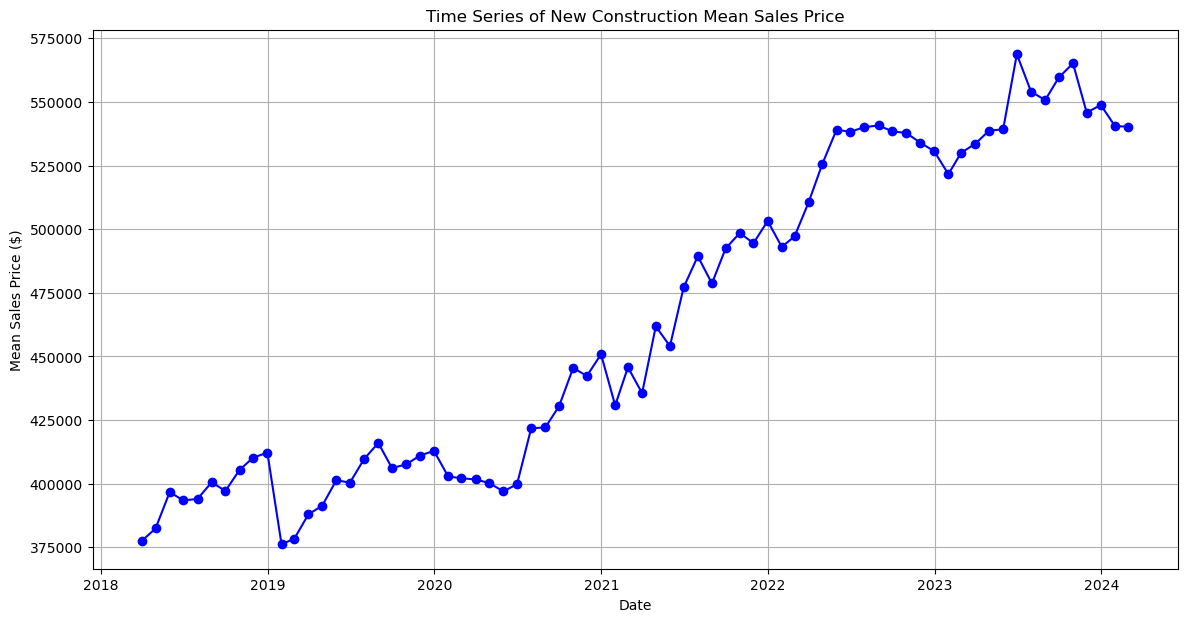

In [9]:
# Convert date to datetime format for better handling
df['date'] = pd.to_datetime(df['date'])

# Group data by date and compute the mean of new construction mean sales price
time_series_data = df.groupby('date')['new construction mean sales price ($)'].mean()

# Plotting the time series of mean sales price
plt.figure(figsize=(14, 7))
plt.plot(time_series_data, marker='o', linestyle='-', color='b')
plt.title('Time Series of New Construction Mean Sales Price')
plt.xlabel('Date')
plt.ylabel('Mean Sales Price ($)')
plt.grid(True)
plt.show()


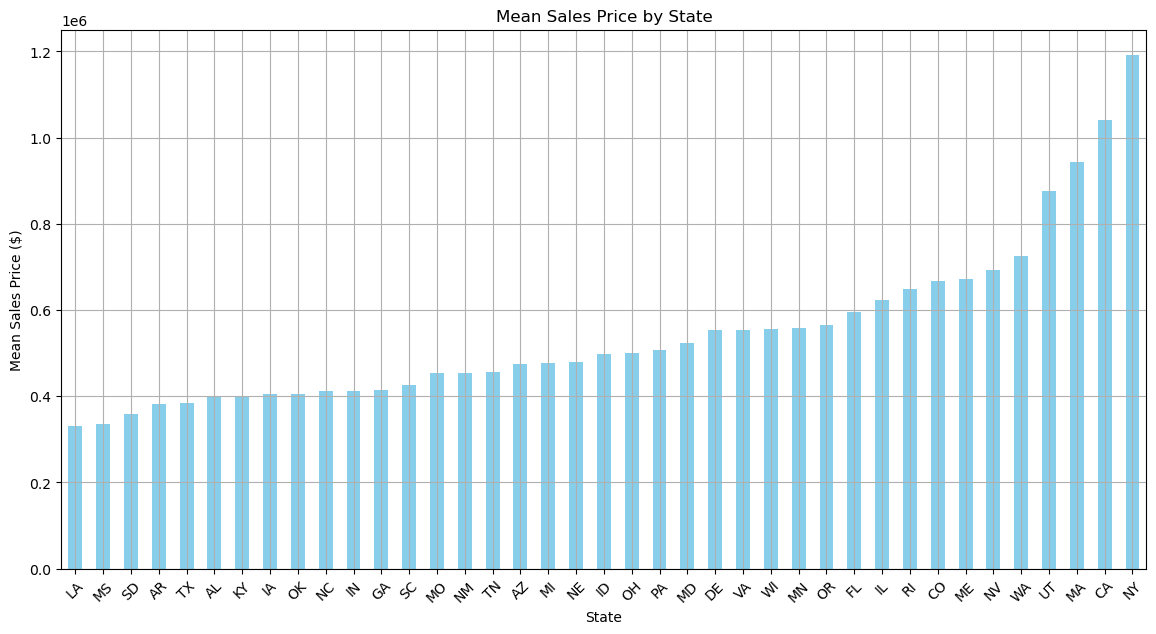

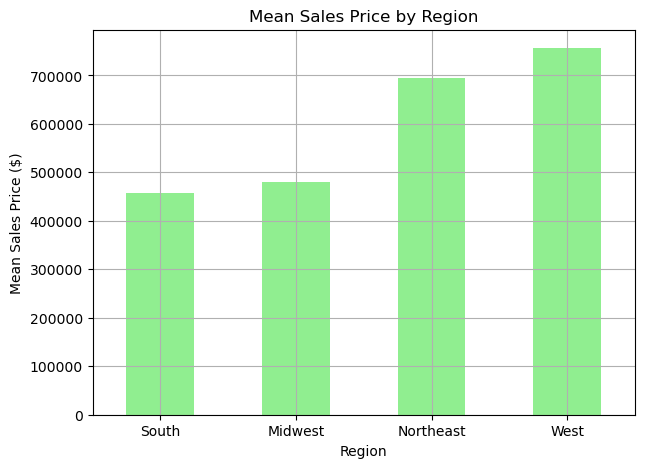

In [10]:
# Filtering data for the most recent date available
latest_data = df[df['date'] == df['date'].max()]

# Group data by state and compute the mean of new construction mean sales price
state_data = latest_data.groupby('statename')['new construction mean sales price ($)'].mean()

# Group data by region and compute the mean of new construction mean sales price
region_data = latest_data.groupby('region')['new construction mean sales price ($)'].mean()

# Plotting mean sales price by state
plt.figure(figsize=(14, 7))
state_data.sort_values().plot(kind='bar', color='skyblue')
plt.title('Mean Sales Price by State')
plt.xlabel('State')
plt.ylabel('Mean Sales Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting mean sales price by region
plt.figure(figsize=(7, 5))
region_data.sort_values().plot(kind='bar', color='lightgreen')
plt.title('Mean Sales Price by Region')
plt.xlabel('Region')
plt.ylabel('Mean Sales Price ($)')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


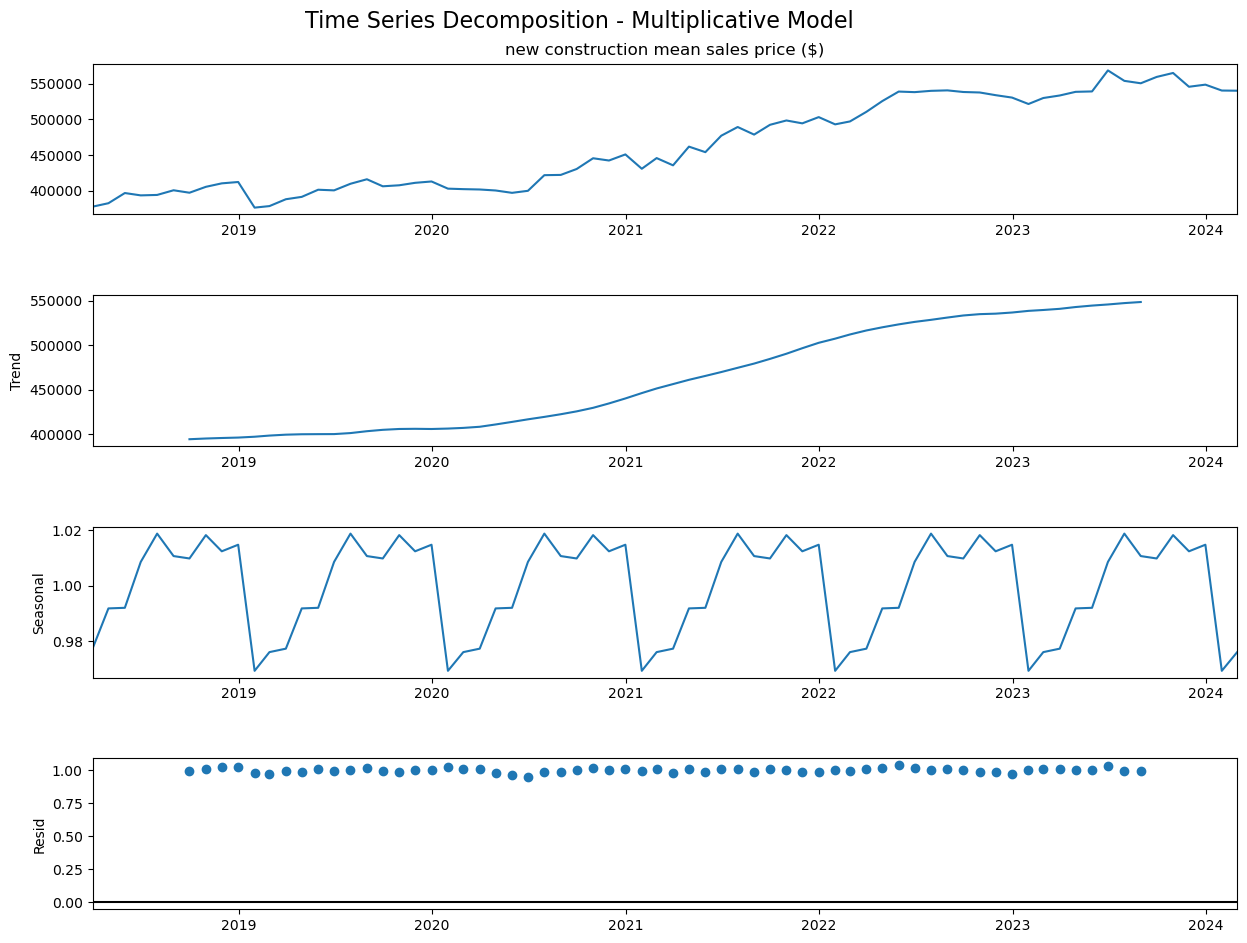

In [11]:
# Decomposing the full time series using a multiplicative model
full_decomposition = seasonal_decompose(time_series_data, model='multiplicative', period=12)

# Plotting the decomposed components
fig_full = full_decomposition.plot()
fig_full.set_size_inches(14, 10)
fig_full.suptitle('Time Series Decomposition - Multiplicative Model', fontsize=16)
plt.show()


In [15]:

# Sort the data by date
df = df.sort_values('date')

# Using the 'new construction mean sales price ($)' column for time series analysis
time_series_full = df.groupby('date')['new construction mean sales price ($)'].mean()

# Splitting the data into train and test sets (80/20 split)
train_data, test_data = train_test_split(time_series_full, test_size=0.2, shuffle=False)

# Output the date ranges for clarity
train_data.index.min(), train_data.index.max(), test_data.index.min(), test_data.index.max()


(Timestamp('2018-03-31 00:00:00'),
 Timestamp('2022-11-30 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2024-02-29 00:00:00'))

In [19]:

# Function to perform the Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Function to perform the KPSS test
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')


In [21]:
# Perform ADF and KPSS tests on original data
print("ADF Test Results on Original Data:")
adf_test(train_data)
print("\nKPSS Test Results on Original Data:")
kpss_test(train_data)

ADF Test Results on Original Data:
ADF Statistic: 0.11431770169631963
p-value: 0.9670251436659639
Critical Values:
   1%: -3.5552728880540942
   5%: -2.9157312396694217
   10%: -2.5956695041322315

KPSS Test Results on Original Data:
KPSS Statistic: 1.1253147421754428
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


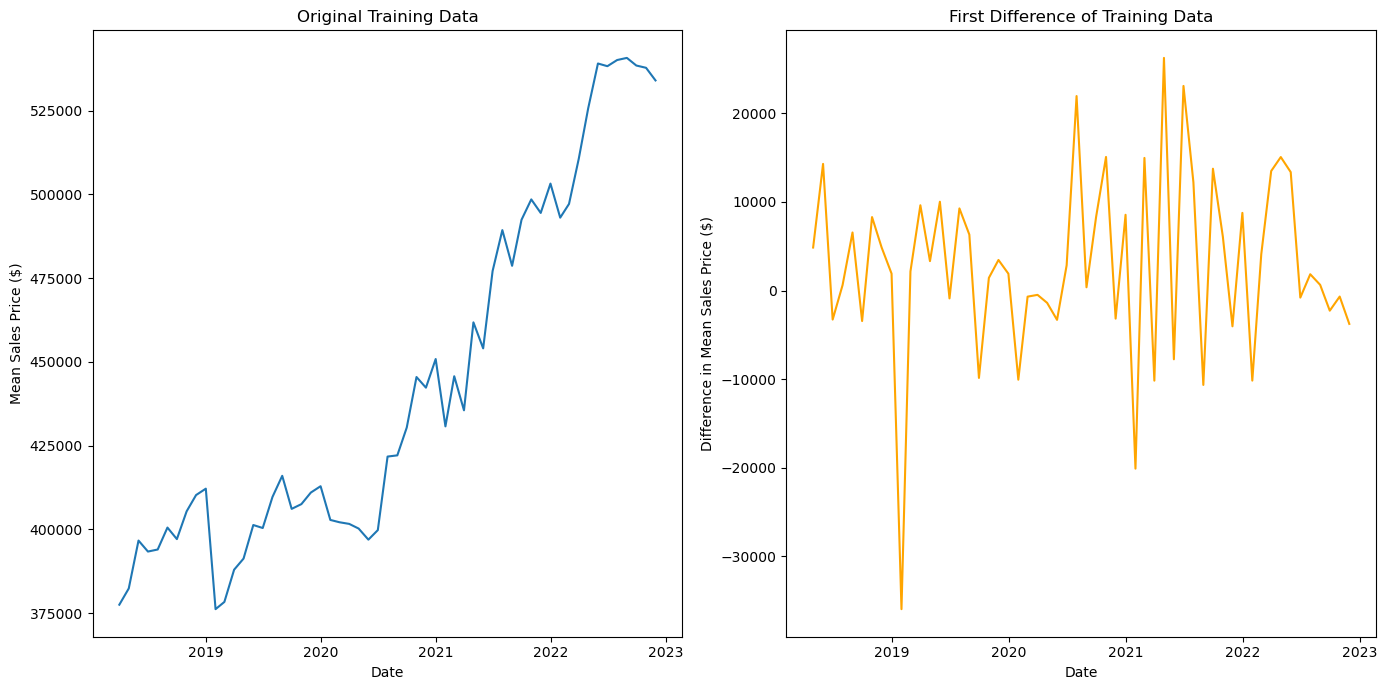


ADF Test Results on Differenced Data:
ADF Statistic: -9.086729069327971
p-value: 3.922000343345859e-15
Critical Values:
   1%: -3.5552728880540942
   5%: -2.9157312396694217
   10%: -2.5956695041322315

KPSS Test Results on Differenced Data:
KPSS Statistic: 0.09386969890854364
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [22]:

# Calculate first difference
train_data_diff = train_data.diff().dropna()

# Plotting the original and differenced data
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(train_data)
plt.title('Original Training Data')
plt.xlabel('Date')
plt.ylabel('Mean Sales Price ($)')

plt.subplot(122)
plt.plot(train_data_diff, color='orange')
plt.title('First Difference of Training Data')
plt.xlabel('Date')
plt.ylabel('Difference in Mean Sales Price ($)')

plt.tight_layout()
plt.show()

# Perform ADF and KPSS tests on differenced data
print("\nADF Test Results on Differenced Data:")
adf_test(train_data_diff)
print("\nKPSS Test Results on Differenced Data:")
kpss_test(train_data_diff, regression='c')  # 'c' for constant only trend

/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


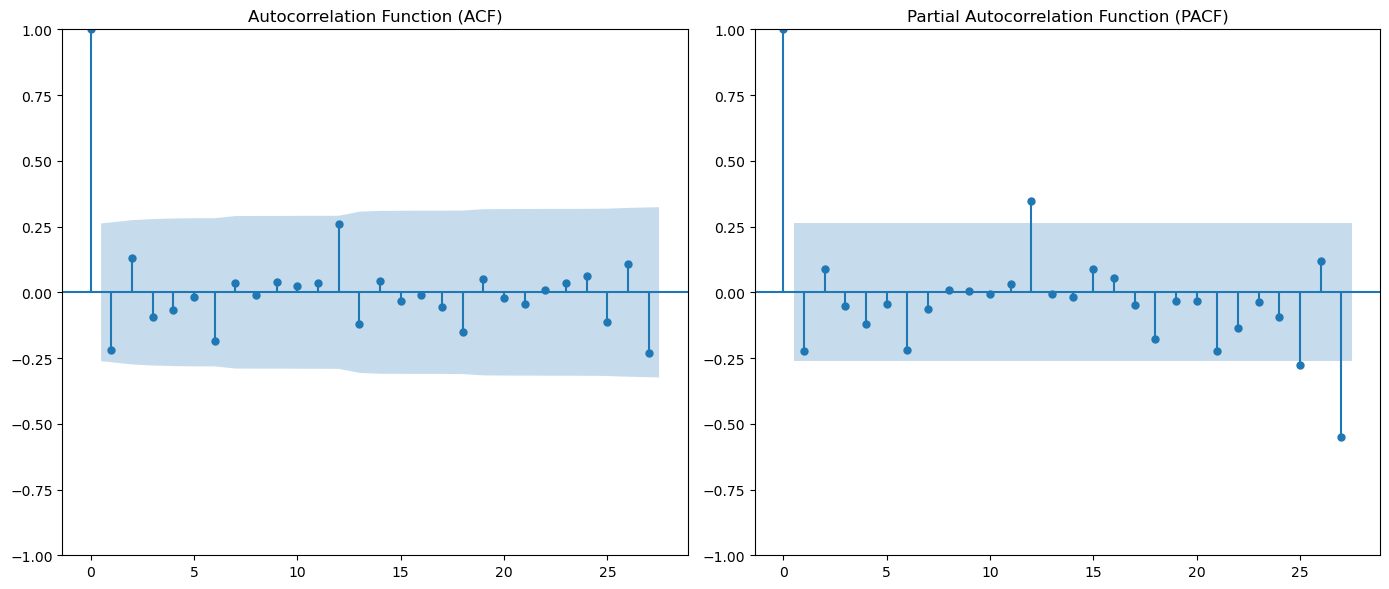

In [25]:
# Recalculate appropriate lags for the PACF (50% of the sample size)
max_lags = len(train_data_diff) // 2 - 1

# Plotting ACF and PACF with appropriate number of lags
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(train_data_diff, ax=plt.gca(), lags=max_lags)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(train_data_diff, ax=plt.gca(), lags=max_lags)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1202.139, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1198.405, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1200.583, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1200.441, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1200.348, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.109 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -597.203
Date:                Fri, 03 May 2024   AIC                           1198.405
Time:                        23:23:33   BIC                           1202.456
Sample:                    03-31-2018   HQIC                          1199.976
                         - 11-30-2022                                       

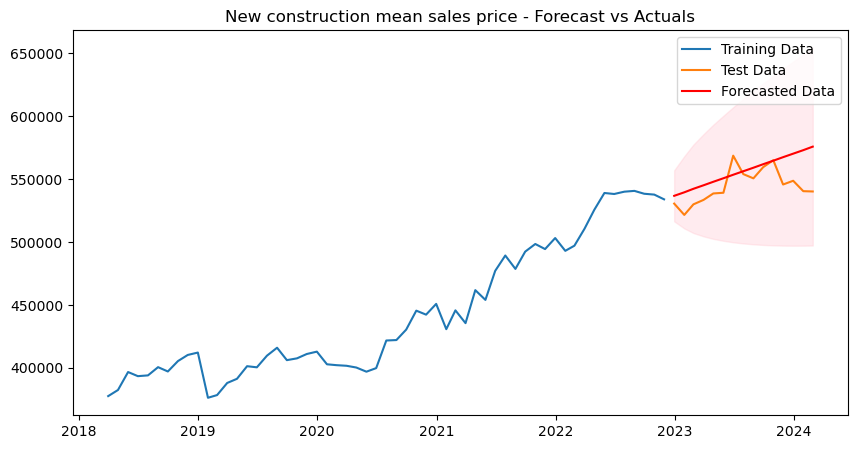

In [33]:
# Running auto_arima to find the best ARIMA model parameters
auto_model = auto_arima(train_data, start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

# Summary of the auto_arima model
print(auto_model.summary())

# Forecasting
forecast, conf_int = auto_model.predict(n_periods=len(test_data), return_conf_int=True)

# Plotting the forecast along with the confidence interval
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='Forecasted Data', color='red')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('New construction mean sales price - Forecast vs Actuals')
plt.legend()
plt.show()